In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2

%load_ext autoreload
%autoreload 2

def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H

    voc = []

    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))

    return [int(v) for v in voc]

In [2]:
import sys
 
# setting path
sys.path.append('../')

In [3]:
from bbox_utils import *

In [4]:
feature_map_shapes = [38, 19, 10, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

In [5]:
prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)

2022-08-25 12:51:04.613264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
boxes = convert_to_box_form(prior_boxes)

In [26]:
gt_boxes = tf.constant([[
    [0.5, 0.5, 0.8, 0.9],
    [0.1, 0.8, 0.2, 0.9]
]
])

gt_labels = tf.constant([
            [1, 2]
])

threshold = 0.5
number_of_labels = 20

In [27]:
gt_boxes[:, :, 0]

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.1]], dtype=float32)>

In [28]:
gt_boxes_offset_to_prior, gt_labels_map_to_prior = match_priors_with_gt(prior_boxes, boxes, gt_boxes, 
                                                                        gt_labels, number_of_labels, threshold)

In [35]:
i = 0
for gt in gt_boxes_offset_to_prior[0,:,:]:
    c_x, c_y, width, height = gt.numpy()
    
    if c_x != 0 and c_y != 0:
        
        start_x, start_y, end_x, end_y = boxes[i, :].numpy()
    
        start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)
        
        print(start_x, start_y, end_x, end_y)
    i+=1

26 232 59 265
26 240 59 273
34 240 67 273
158 158 236 236
158 174 236 252
158 189 236 268
159 168 260 300
168 145 251 300


In [34]:
boxes[1040,:]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.11628038, 0.8004909 , 0.22582489, 0.91003543], dtype=float32)>

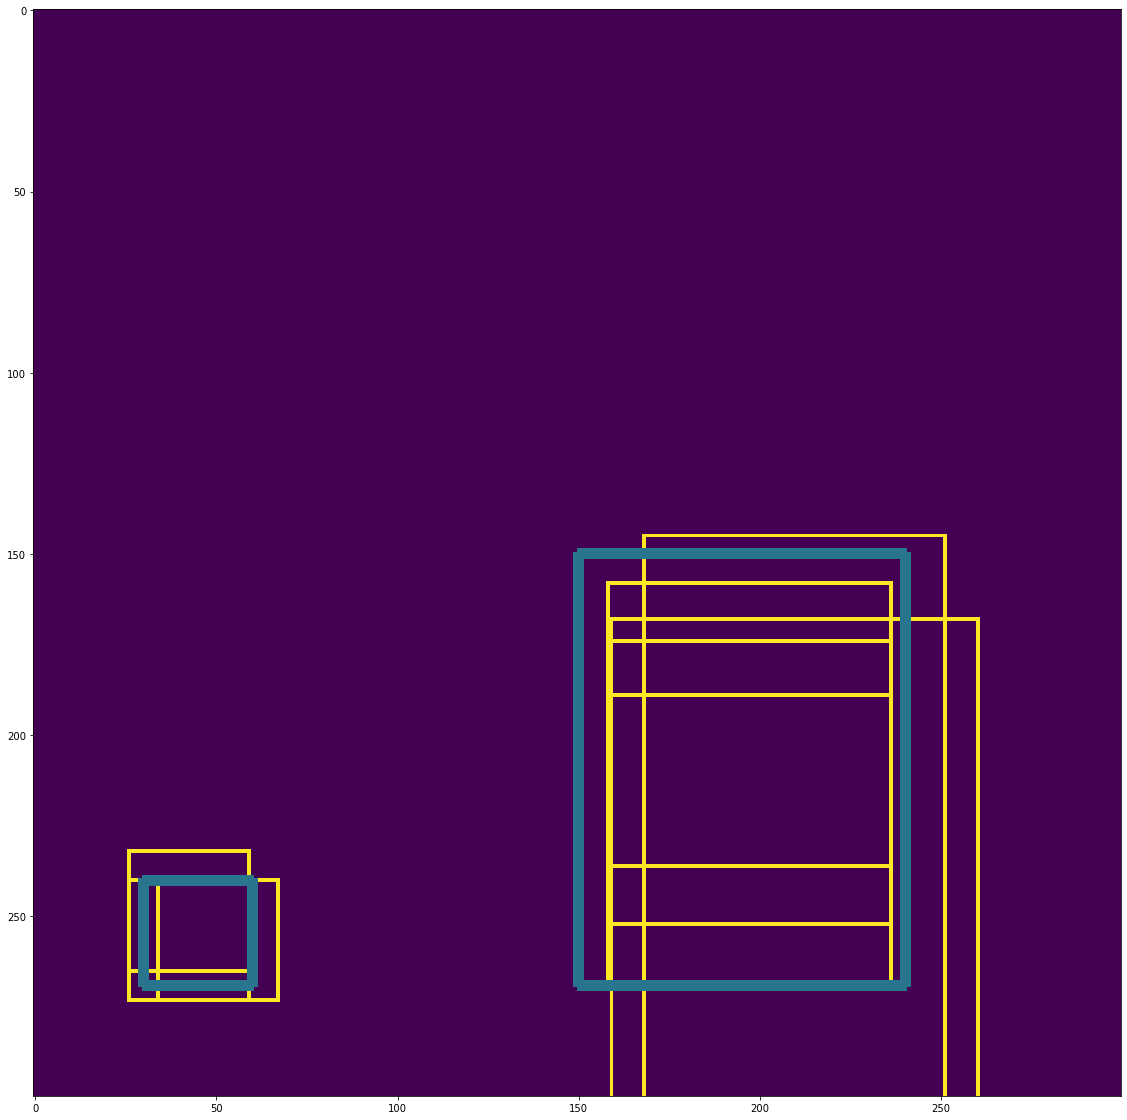

In [30]:
image_width = 300
image_height = 300
gt_color = (100, 100, 0)
color = (255, 0, 0)

image = np.ones((image_width, image_height))

i = 0
for gt in gt_boxes_offset_to_prior[0,:,:]:
    c_x, c_y, width, height = gt.numpy()
    
    if c_x != 0 and c_y != 0:
        
        start_x, start_y, end_x, end_y = boxes[i, :].numpy()
    
        start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)

        image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color, thickness = 1)
    i+=1
    
# draw gt_boxes
for gt in gt_boxes[0,:,:]:
    start_x, start_y, end_x, end_y = gt.numpy()

    start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)
#     print(start_x, start_y, end_x, end_y )
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], gt_color, thickness = 2)

plt.figure(figsize = (20,20))
plt.imshow(image)

In [ ]:
boxes

In [ ]:
tf.transpose(boxes, perm=[0, 2, 1])